In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [3]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [4]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [5]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [6]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [7]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [8]:
X = StandardScaler().fit_transform(X)
#X = PCA().fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [10]:
def createModel():
    model = Sequential([
                    Dense(256, input_dim=X.shape[1], activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [11]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [12]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1

def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [13]:
crossValidation(K=10)

F1 Score in fold 1 = 0.9683257918552036
F1 Score in fold 2 = 0.9722222222222222
F1 Score in fold 3 = 0.9603524229074888
F1 Score in fold 4 = 0.9755011135857461
F1 Score in fold 5 = 0.9741176470588235
F1 Score in fold 6 = 0.9710743801652894
F1 Score in fold 7 = 0.9814432989690721
F1 Score in fold 8 = 0.9764453961456103
F1 Score in fold 9 = 0.9818181818181819
F1 Score in fold 10 = 0.9753914988814317
Average 10-Fold F1 Score = 0.9736691953609069

F1 Score in fold 1 = 0.989106753812636
F1 Score in fold 2 = 0.989010989010989
F1 Score in fold 3 = 0.9601769911504425
F1 Score in fold 4 = 0.9650655021834061
F1 Score in fold 5 = 0.9803063457330414
F1 Score in fold 6 = 0.989010989010989
F1 Score in fold 7 = 0.9779735682819384
F1 Score in fold 8 = 0.9694323144104804
F1 Score in fold 9 = 0.982532751091703
F1 Score in fold 10 = 0.9671772428884027
Average Stratified 10-Fold F1 Score = 0.9769793447574029


In [14]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [15]:
performance(y_test, pred)

F1 Score: 0.9787798408488064
Kappa Score: 0.9683632834490928
Accuracy Score: 0.9835320047184454
Confusion Matrix:
[[1520   14]
 [  18  738]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.99      0.99      0.99      2290



In [16]:
saveModel(model, "../model/nn-model.h5")

In [17]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

In [18]:
eli5.explain_weights(perm, feature_names = TO_USE)

Weight,Feature
0.1418 ± 0.0042,koi_fpflag_ss
0.1281 ± 0.0073,koi_fpflag_co
0.1172 ± 0.0050,koi_fpflag_nt
0.0651 ± 0.0047,koi_fpflag_ec
0.0529 ± 0.0022,koi_depth
0.0367 ± 0.0021,koi_period
0.0363 ± 0.0039,koi_duration
0.0309 ± 0.0013,koi_teq
0.0195 ± 0.0014,koi_slogg
0.0194 ± 0.0039,koi_steff


In [19]:
perm.feature_importances_

array([0.00489985, 0.01397896, 0.01951289, 0.03625883, 0.06511025,
       0.0008935 , 0.05288947, 0.0193976 , 0.00368929, 0.00115291,
       0.00582217, 0.00443867, 0.12814527, 0.11716386, 0.00276698,
       0.03089782, 0.14177836, 0.00138347, 0.03671998])

In [20]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

In [21]:
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_ss,0.141778
1,koi_fpflag_co,0.128145
2,koi_fpflag_nt,0.117164
3,koi_fpflag_ec,0.065110
4,koi_depth,0.052889


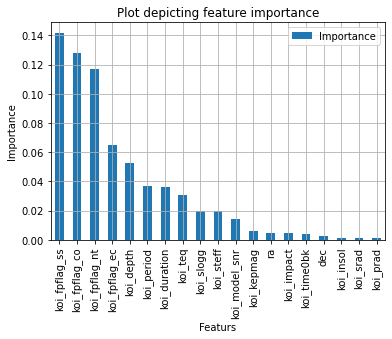

In [22]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Featurs')
plt.ylabel('Importance')
plt.show()